## This notebook will construct the nodes and edges that we will build our graph with

In this notebook we use peaks that have been extracted from the spectra to construct a graph. Each node in the graph will be a peak, with attributes such as width of that peak, its Status, etc. . Edges between two peaks will exist based on two conditions. The first condition is that every peak, within a sample, will be connected to each other. The second condition is based on matching grid-slots. This means we will parse our spectra into grid squares and if two peaks are present in the same grid square, a relationjship will exist between them.

These relationships will be weighted by distance. That means we treat each peak as a point in a co-ordinate plane and calculate the euclidean distance between them. As the peaks in the same grid-slots will inherently be closer to each other than the peaks in the same sample, we will separately minmax scale these distances, so as not to give prefernece to one type of relationship. As well as this, in a graph, a larger weight is meant to represent a stronger connection between nodes. In order to account for this, we will get the inverse of our scaled distance to used as the relationship weight as we want peaks that are closer together to have a stronger connection.

Import relevant libraries and import raw data

In [1]:
import seaborn as sns
import pandas as pd
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
os_name = os.name

if os_name == 'nt':
    password = os.getenv('NEO4J_Password')
    neo4j_directory = os.getenv('NEO4J_Directory')
else:
    password = os.environ['NEO4J_Password']
    neo4j_directory = os.environ['NEO4J_Directory']

In [3]:
#df = pd.read_csv("../data/exosomes.raw_spectrum_1.csv")

In [4]:
#df = pd.read_csv("../data/current_clean_spectrum.csv")
#df = pd.read_csv("../data/initial_parameters.csv")
df = pd.read_csv("../data/groupkfold_parameters.csv")

In [5]:
df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
0,201210-1-00,293,400.22778,201210-1,Normal,41.863303
1,201210-1-00,294,400.91116,201210-1,Normal,41.803843
2,201210-1-00,295,401.59454,201210-1,Normal,41.741884
3,201210-1-00,296,402.27789,201210-1,Normal,41.677722
4,201210-1-00,297,402.96127,201210-1,Normal,41.611654
...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,210526-3,Hyperglycemia,12.378163
6239201,210526-3-09,2338,1797.72200,210526-3,Hyperglycemia,13.269937
6239202,210526-3-09,2339,1798.40550,210526-3,Hyperglycemia,14.199285
6239203,210526-3-09,2340,1799.08890,210526-3,Hyperglycemia,15.166531


Here we use scipy's function "find_peaks" to find all peaks in each individual spectra sample as well as pulling featurse such as prominence and width of peaks

In [6]:
peaks = []
widths = []
prom = []

for _, group in df.groupby('SpecID'):
    peak_index, weights = find_peaks(x=group['Absorbance'], prominence=72, width=6)
    peaks += list(group.iloc[peak_index].index.values)
    widths += list(weights['widths'])
    prom += list(weights['prominences'])

In [7]:
print(len(peaks))

27666


Below shows a scatterplot of the coordinates of all the peaks we have found

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

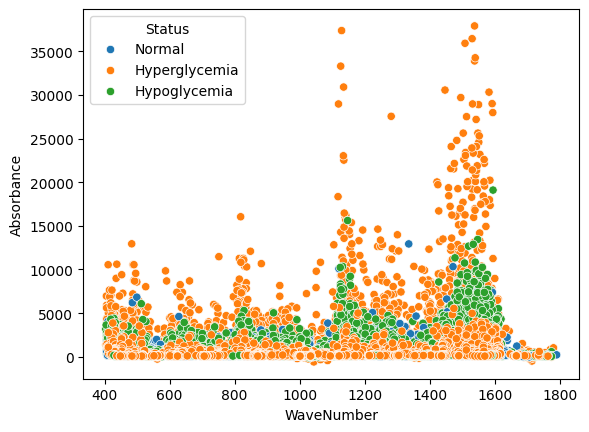

In [8]:
sns.scatterplot(data=df.iloc[peaks].reset_index(), x="WaveNumber", y="Absorbance", hue="Status")

We then add the peak information to our main dataframe

In [9]:
peak_df = df.iloc[peaks]
peak_df['Widths'] = widths
peak_df['Prominences'] = prom

/tmp/ipykernel_243636/2901317241.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_df['Widths'] = widths
/tmp/ipykernel_243636/2901317241.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_df['Prominences'] = prom


We then use the function to assign each peak we have found to a grid slot. We have speicified the slot sizes as they give a meaningful overlap to build our graph

In [10]:
def assign_to_grid(x, y, x_slot_size, y_slot_size):

    x_index = int(x / x_slot_size)
    y_index = int(y / y_slot_size)

    return x_index, y_index

In [11]:
# Set the size of the grid slots
WaveNumber_slot_size = 50
Absorbance_slot_size = 100

peak_df['GridSlot'] = peak_df.apply(lambda row: assign_to_grid(row['WaveNumber'], row['Absorbance'], WaveNumber_slot_size, Absorbance_slot_size), axis=1)

/tmp/ipykernel_243636/2339617849.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_df['GridSlot'] = peak_df.apply(lambda row: assign_to_grid(row['WaveNumber'], row['Absorbance'], WaveNumber_slot_size, Absorbance_slot_size), axis=1)


In [12]:
peak_df['GridSlot'].nunique()

1581

In [13]:
peak_df.head()

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,Widths,Prominences,GridSlot
317,201210-1-00,610,616.85651,201210-1,Normal,144.138364,54.704953,126.932045,"(12, 1)"
433,201210-1-00,726,696.12756,201210-1,Normal,173.397843,47.454747,169.566634,"(13, 1)"
728,201210-1-00,1021,897.72211,201210-1,Normal,112.769421,119.577556,114.152501,"(17, 1)"
881,201210-1-00,1174,1002.27790,201210-1,Normal,105.303597,84.661040,83.068030,"(20, 1)"
1791,201210-1-00,2084,1624.14580,201210-1,Normal,102.777868,194.114304,103.238282,"(32, 1)"


We will use "Node_ID" to find distances between peaks later on for our edge construction

In [14]:
peak_df['Node_ID'] = peak_df.index

/tmp/ipykernel_243636/412265839.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_df['Node_ID'] = peak_df.index


In [15]:
peak_df = peak_df.drop(columns=['Seq', 'SurID'])

Here we join the peak dataframe with itself in order to match peaks within the same Spectra Sample

In [16]:
same_sample = pd.merge(peak_df, peak_df[['SpecID', 'Node_ID']], on='SpecID', how='outer', suffixes=('_src', '_dst'))
same_sample['LINK:TYPE'] = 'SAMPLE'

In [17]:
same_sample.head()

,SpecID,WaveNumber,Status,Absorbance,Widths,Prominences,GridSlot,Node_ID_src,Node_ID_dst,LINK:TYPE
0,201210-1-00,616.85651,Normal,144.138364,54.704953,126.932045,"(12, 1)",317,317,SAMPLE
1,201210-1-00,616.85651,Normal,144.138364,54.704953,126.932045,"(12, 1)",317,433,SAMPLE
2,201210-1-00,616.85651,Normal,144.138364,54.704953,126.932045,"(12, 1)",317,728,SAMPLE
3,201210-1-00,616.85651,Normal,144.138364,54.704953,126.932045,"(12, 1)",317,881,SAMPLE
4,201210-1-00,616.85651,Normal,144.138364,54.704953,126.932045,"(12, 1)",317,1791,SAMPLE


We then join the dataframe with itself again, this time to match peaks in the same grid slot

In [18]:
same_grid_slot = pd.merge(peak_df, peak_df[['GridSlot', 'Node_ID']], on='GridSlot', how='outer', suffixes=('_src', '_dst'))
same_grid_slot['LINK:TYPE'] = 'GRID'

In [19]:
same_grid_slot.head()

,SpecID,WaveNumber,Status,Absorbance,Widths,Prominences,GridSlot,Node_ID_src,Node_ID_dst,LINK:TYPE
0,201210-1-00,616.85651,Normal,144.138364,54.704953,126.932045,"(12, 1)",317,317,GRID
1,201210-1-00,616.85651,Normal,144.138364,54.704953,126.932045,"(12, 1)",317,2374,GRID
2,201210-1-00,616.85651,Normal,144.138364,54.704953,126.932045,"(12, 1)",317,8522,GRID
3,201210-1-00,616.85651,Normal,144.138364,54.704953,126.932045,"(12, 1)",317,10569,GRID
4,201210-1-00,616.85651,Normal,144.138364,54.704953,126.932045,"(12, 1)",317,49484,GRID


We the combine these new dataframes together to form our relationship dataframe and we perform some clean to get rid of columns we don't need and renaming columns to get them ready for neo4j

In [20]:
graph_df = pd.concat([same_sample, same_grid_slot], ignore_index=True)

In [21]:
graph_df

,SpecID,WaveNumber,Status,Absorbance,Widths,Prominences,GridSlot,Node_ID_src,Node_ID_dst,LINK:TYPE
0,201210-1-00,616.85651,Normal,144.138364,54.704953,126.932045,"(12, 1)",317,317,SAMPLE
1,201210-1-00,616.85651,Normal,144.138364,54.704953,126.932045,"(12, 1)",317,433,SAMPLE
2,201210-1-00,616.85651,Normal,144.138364,54.704953,126.932045,"(12, 1)",317,728,SAMPLE
3,201210-1-00,616.85651,Normal,144.138364,54.704953,126.932045,"(12, 1)",317,881,SAMPLE
4,201210-1-00,616.85651,Normal,144.138364,54.704953,126.932045,"(12, 1)",317,1791,SAMPLE
...,...,...,...,...,...,...,...,...,...,...
4198141,210510-2-36,1602.27800,Hyperglycemia,2527.063745,31.756654,465.994185,"(32, 25)",5421364,5413198,GRID
4198142,210510-2-36,1602.27800,Hyperglycemia,2527.063745,31.756654,465.994185,"(32, 25)",5421364,5421364,GRID
4198143,210510-2-41,1601.59450,Hyperglycemia,3323.487187,15.184140,240.715426,"(32, 33)",5433657,5433657,GRID
4198144,210510-2-42,1602.27800,Hyperglycemia,3191.571207,55.292032,1462.715238,"(32, 31)",5435707,5435707,GRID


In [22]:
del same_sample
del same_grid_slot

In [23]:
graph_df = graph_df.drop(columns=['SpecID', 'GridSlot', 'WaveNumber', 'Absorbance', 'Status', 'Widths', 'Prominences'])

In [24]:
graph_df = graph_df.rename(columns={'Node_ID_src':':START_ID', 'Node_ID_dst':':END_ID'})

In [25]:
graph_df

,:START_ID,:END_ID,LINK:TYPE
0,317,317,SAMPLE
1,317,433,SAMPLE
2,317,728,SAMPLE
3,317,881,SAMPLE
4,317,1791,SAMPLE
...,...,...,...
4198141,5421364,5413198,GRID
4198142,5421364,5421364,GRID
4198143,5433657,5433657,GRID
4198144,5435707,5435707,GRID


This gets rid of relationships that match nodes to themselves

In [26]:
graph_df = graph_df[graph_df[':START_ID'] != graph_df[':END_ID']]

We make use of built in numpy functions to efficiently calculate distances between all of our relationships

In [27]:
wave = peak_df['WaveNumber']
absorb = peak_df['Absorbance']

src_indices = graph_df[':START_ID'].values
dst_indices = graph_df[':END_ID'].values

src_coords = np.column_stack((wave[src_indices], absorb[src_indices]))
dst_coords = np.column_stack((wave[dst_indices], absorb[dst_indices]))

distances = np.linalg.norm(src_coords - dst_coords, axis=1)

dist = distances.tolist()

In [28]:
graph_df['DIST'] = dist

/tmp/ipykernel_243636/3060805488.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graph_df['DIST'] = dist


In [29]:
graph_df.head()

,:START_ID,:END_ID,LINK:TYPE,DIST
1,317,433,SAMPLE,84.498618
2,317,728,SAMPLE,282.611917
3,317,881,SAMPLE,387.372930
4,317,1791,SAMPLE,1008.138088
5,433,317,SAMPLE,84.498618


In [30]:
from sklearn.preprocessing import MinMaxScaler

sample_data = graph_df[graph_df['LINK:TYPE'] == 'SAMPLE']
grid_data = graph_df[graph_df['LINK:TYPE'] == 'GRID']

scaler = MinMaxScaler()

sample_data['DIST'] = 1 - scaler.fit_transform(sample_data[['DIST']])
grid_data['DIST'] = 1 -scaler.fit_transform(grid_data[['DIST']])

scaled_df = pd.concat([sample_data, grid_data])

/tmp/ipykernel_243636/945116818.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_data['DIST'] = 1 - scaler.fit_transform(sample_data[['DIST']])
/tmp/ipykernel_243636/945116818.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grid_data['DIST'] = 1 -scaler.fit_transform(grid_data[['DIST']])


In [31]:
scaled_df.rename(columns={'DIST':'DIST:float'}, inplace=True)

In [32]:
scaled_df.head()

,:START_ID,:END_ID,LINK:TYPE,DIST:float
1,317,433,SAMPLE,0.998217
2,317,728,SAMPLE,0.992950
3,317,881,SAMPLE,0.990164
4,317,1791,SAMPLE,0.973661
5,433,317,SAMPLE,0.998217


In [33]:
scaled_df.to_csv(f"{neo4j_directory}/import/relationships.csv", index=False)

Finally, we clean and rename columsn in our main node dataframe to get it ready for neo4j

In [34]:
peak_df

,SpecID,WaveNumber,Status,Absorbance,Widths,Prominences,GridSlot,Node_ID
317,201210-1-00,616.85651,Normal,144.138364,54.704953,126.932045,"(12, 1)",317
433,201210-1-00,696.12756,Normal,173.397843,47.454747,169.566634,"(13, 1)",433
728,201210-1-00,897.72211,Normal,112.769421,119.577556,114.152501,"(17, 1)",728
881,201210-1-00,1002.27790,Normal,105.303597,84.661040,83.068030,"(20, 1)",881
1791,201210-1-00,1624.14580,Normal,102.777868,194.114304,103.238282,"(32, 1)",1791
...,...,...,...,...,...,...,...,...
6218345,210526-3-44,1547.60820,Hyperglycemia,86.569295,143.849024,82.834577,"(30, 0)",6218345
6220413,210526-3-45,1560.59230,Hyperglycemia,80.347359,204.479552,79.065288,"(31, 0)",6220413
6222466,210526-3-46,1563.32570,Hyperglycemia,79.644840,205.361570,79.440749,"(31, 0)",6222466
6226554,210526-3-48,1556.49210,Hyperglycemia,76.083722,145.050916,72.123217,"(31, 0)",6226554


In [35]:
peak_df.rename(columns={"Status":"Status:LABEL"}, inplace=True)

In [36]:
peak_df.rename(columns={'WaveNumber':'WaveNumber:float', 'Absorbance':'Absorbance:float', 'Widths':'Widths:float', 'Prominences':'Prominences:float', 'Node_ID':'Node_ID:ID'}, inplace=True)

In [37]:
peak_df.to_csv(f'{neo4j_directory}/import/nodes.csv', index=False)

#### Creating Graph and Running Queries in Neo4j

In [38]:
from neo4j import GraphDatabase
import os
import pandas as pd
import shutil
import subprocess

In [39]:
del graph_df
del scaled_df
del peak_df
del df

In [40]:
del dist

This moves the nodes and relationships files from data/current_working_graph into the DBMS import folder.

At the moment this uses local paths, but the rest should be automated.

Then run the admin import command.

In [41]:
os_name = os.name

if os_name == 'nt':
    working_dir = f'{neo4j_directory}/bin'
    command = 'neo4j-admin database import full --nodes=import/nodes.csv --relationships=import/relationships.csv --overwrite-destination neo4j'
    result = subprocess.run(command, shell=True, cwd=working_dir, capture_output=True, text=True)
else:
    working_dir = f'{neo4j_directory}'
    command = [
    './bin/neo4j-admin', 'database', 'import', 'full',
    '--nodes=import/nodes.csv',
    '--relationships=import/relationships.csv',
    '--overwrite-destination',  'neo4j'
    ]
    result = subprocess.run(command, cwd=working_dir, stdout=subprocess.PIPE, stderr=subprocess.PIPE)


# Check if the command was successful
if result.returncode == 0:
    print("Import successful")
    print(result.stdout)
else:
    print("Error during import:")
    print(result.stderr)

Import successful
b"Neo4j version: 5.12.0\nImporting the contents of these files into /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/data/databases/neo4j:\nNodes:\n  /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/import/nodes.csv\n\nRelationships:\n  /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/import/relationships.csv\n\n\nAvailable resources:\n  Total machine memory: 15.47GiB\n  Free machine memory: 1.408GiB\n  Max heap memory : 910.5MiB\n  Max worker threads: 8\n  Configured max memory: 661.2MiB\n  High parallel IO: true\n\nCypher type normalization is enabled (disable with --normalize-types=false):\n  Property type of 'WaveNumber' normalized from 'float' --> 'double' in /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/import/nodes.csv\n  Property typ

In [42]:
if os_name != 'nt':
    command = [
        './bin/neo4j', 'restart'
    ]

    result = subprocess.run(command, cwd=neo4j_directory, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

    # Check if the command was successful
    if result.returncode == 0:
        print("Restart successful")
        print(result.stdout)
    else:
        print("Error during restart:")
        print(result.stderr)

Restart successful
b'Stopping Neo4j......... stopped.\nConfiguration file validation successful (with warnings).\nDirectories in use:\nhome:         /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5\nconfig:       /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/conf\nlogs:         /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/logs\nplugins:      /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/plugins\nimport:       /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/import\ndata:         /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/data\ncertificates: /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9f

Run and connect to the Neo4j Database

In [43]:
from neo4j import GraphDatabase

uri = "neo4j://localhost:7687"
username = "neo4j"              # Neo4J username
#Passwords is defined at the top of the notebook

# Create a driver instance
driver = GraphDatabase.driver(uri, auth=(username, password))

# Ensure you close the driver connection when your program ends
def close_driver():
    driver.close()

**First create the gds Graph Projection**

In [44]:
def project_graph(tx):
    query = """
    CALL gds.graph.project(
      'myGraph', 
      ['Normal', 'Hyperglycemia', 'Hypoglycemia'],
      {
        SAMPLE: {
          orientation: 'UNDIRECTED',
          properties: 'DIST'
        },
        GRID: {
          orientation: 'UNDIRECTED',
          properties: 'DIST'
        }
      }
    )
    """
    tx.run(query)

# Use a session to execute the graph projection
with driver.session() as session:
    session.execute_write(project_graph)

Unable to retrieve routing information
Transaction failed and will be retried in 1.0928495792943203s (Unable to retrieve routing information)
Unable to retrieve routing information
Transaction failed and will be retried in 2.305899984572461s (Unable to retrieve routing information)
Unable to retrieve routing information
Transaction failed and will be retried in 3.73238866621064s (Unable to retrieve routing information)
Unable to retrieve routing information
Transaction failed and will be retried in 8.879463148156876s (Unable to retrieve routing information)


Define the graph algorithms.

In [45]:
def run_pagerank_centrality(tx):
    query = """
    CALL gds.pageRank.stream('myGraph', {
        relationshipWeightProperty: 'DIST'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, gds.util.asNode(nodeId).Node_ID AS id, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["id"], record["score"]) for record in results]

In [46]:
def run_degree_centrality(tx):
    query = """
    CALL gds.degree.stream('myGraph', {
        relationshipWeightProperty: 'DIST'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, gds.util.asNode(nodeId).Node_ID AS id, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["id"], record["score"]) for record in results]

In [47]:
def run_eigenvector_centrality(tx):
    query = """
    CALL gds.eigenvector.stream('myGraph', {
        relationshipWeightProperty: 'DIST'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, gds.util.asNode(nodeId).Node_ID AS id, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["id"], record["score"]) for record in results]

In [48]:
def run_articlerank_centrality(tx):
    query = """
    CALL gds.articleRank.stream('myGraph', {
        relationshipWeightProperty: 'DIST'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, gds.util.asNode(nodeId).Node_ID AS id, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["id"], record["score"]) for record in results]

In [49]:
def run_label_propagation_algorithm(tx):
    query = """
    CALL gds.labelPropagation.stream('myGraph', { relationshipWeightProperty: 'DIST' })
    YIELD nodeId, communityId AS Community
    RETURN gds.util.asNode(nodeId).SpecID AS name, gds.util.asNode(nodeId).Node_ID AS id, Community
    ORDER BY Community, name
    """
    results = tx.run(query)
    return [(record["name"], record["id"], record["Community"]) for record in results]

In [50]:
def run_leiden_algorithm(tx):
    query = """
    CALL gds.leiden.stream('myGraph', { relationshipWeightProperty: 'DIST' })
    YIELD nodeId, communityId AS Community
    RETURN gds.util.asNode(nodeId).SpecID AS name, gds.util.asNode(nodeId).Node_ID AS id, Community
    ORDER BY Community, name
    """
    results = tx.run(query)
    return [(record["name"], record["id"], record["Community"]) for record in results]

In [51]:
def run_louvain_algorithm(tx):
    query = """
    CALL gds.louvain.stream('myGraph', { relationshipWeightProperty: 'DIST' })
    YIELD nodeId, communityId AS Community
    RETURN gds.util.asNode(nodeId).SpecID AS name, gds.util.asNode(nodeId).Node_ID AS id, Community
    ORDER BY Community, name
    """
    results = tx.run(query)
    return [(record["name"], record["id"], record["Community"]) for record in results]

In [52]:
def run_node2vec_algorithm(tx):
    query = """
    CALL gds.node2vec.stream('myGraph', { relationshipWeightProperty: 'Weight' })
    YIELD nodeId, embedding
    RETURN gds.util.asNode(nodeId).SpecID AS name, embedding
    """
    results = tx.run(query)
    return [(record["name"], record["embedding"]) for record in results]

In [53]:
def run_fastRP_algorithm(tx):
    query = """
    CALL gds.fastRP.stream('myGraph',
        { relationshipWeightProperty: 'DIST',
         randomSeed:1234,
         embeddingDimension: 128
        }
    )
    YIELD nodeId, embedding
    RETURN gds.util.asNode(nodeId).SpecID AS name, gds.util.asNode(nodeId).Node_ID AS id, embedding
    """
    results = tx.run(query)
    return [(record["name"], record["id"], record["embedding"]) for record in results]

Execute the algorithms and store the results in a Dataframe.

In [54]:
# Use a session to execute the queries and retrieve the results
with driver.session() as session:
    pagerank_results = session.execute_read(run_pagerank_centrality)
    degree_results = session.execute_read(run_degree_centrality)
    eigenvector_results = session.execute_read(run_eigenvector_centrality)
    articlerank_results = session.execute_read(run_articlerank_centrality)
    label_propagation_results = session.execute_read(run_label_propagation_algorithm)
    leiden_results = session.execute_read(run_leiden_algorithm)
    louvain_results = session.execute_read(run_louvain_algorithm)

In [55]:
pagerank_df = pd.DataFrame(pagerank_results, columns=['name', 'id', 'PageRank'])
degree_df = pd.DataFrame(degree_results, columns=['name', 'id', 'DegreeCentrality'])
eigenvector_df = pd.DataFrame(eigenvector_results, columns=['name', 'id', 'EigenvectorCentrality'])
articlerank_df = pd.DataFrame(articlerank_results, columns=['name', 'id', 'ArticleRank'])
label_propagation_df = pd.DataFrame(label_propagation_results, columns=['name', 'id', 'LabelPropagation'])
leiden_df = pd.DataFrame(leiden_results, columns=['name', 'id', 'Leiden'])
louvain_df = pd.DataFrame(louvain_results, columns=['name', 'id', 'Louvain'])

In [56]:
merged_df = pagerank_df
for df in [degree_df, eigenvector_df, articlerank_df, leiden_df, louvain_df]:
    merged_df = pd.merge(merged_df, df, on=['id', 'name'], how='left')

In [57]:
df = merged_df.rename(columns={'name' : 'SpecID'})
df

,SpecID,id,PageRank,DegreeCentrality,EigenvectorCentrality,ArticleRank,Leiden,Louvain
0,210211-2-08,937327,1.892820,404.289534,0.012843,0.297220,48,1341
1,210211-1-37,894352,1.860073,322.435482,0.012100,0.272042,4,17855
2,210211-1-41,902513,1.815380,594.743458,0.013758,0.351111,131,24102
3,210504-1-36,4908339,1.792832,621.408070,0.014177,0.359678,131,24102
4,210504-1-08,4945220,1.788743,620.567642,0.014080,0.359109,131,24102
...,...,...,...,...,...,...,...,...
27661,210114-2-35,378772,0.298956,29.768324,0.000852,0.161381,0,12976
27662,210225-2-17,1570987,0.296684,25.556263,0.000718,0.159666,0,12976
27663,210303-2-26,1794243,0.289349,21.492568,0.000765,0.158513,4,12976
27664,210114-2-19,345838,0.288640,5.498097,0.000067,0.152317,178,8935


In [58]:
with driver.session() as session:
    fastRP_results = session.execute_read(run_fastRP_algorithm)

fastRP_df = pd.DataFrame(fastRP_results, columns=['SpecID', 'id', 'embeddings'])

# Expand the embeddings list into separate columns
embeddings_df = pd.DataFrame(fastRP_df['embeddings'].tolist(), index=fastRP_df.index)

# Optionally, rename the new columns
embeddings_df.columns = [f'embedding_{i}' for i in range(embeddings_df.shape[1])]

# Join the new embeddings columns to the original DataFrame
fastRP_df = pd.concat([fastRP_df.drop(['embeddings'], axis=1), embeddings_df], axis=1)
fastRP_df.to_csv('../../data/fastRP_embeddings.csv', index=False)
fastRP_df.head()

,SpecID,id,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,...,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127
0,201210-1-00,317,0.455145,0.110259,0.181389,0.311032,-0.090650,0.166183,0.127010,0.227703,...,0.105758,-0.134285,0.328452,0.090468,-0.001541,-0.061959,-0.004671,-0.117618,-0.439367,-0.049186
1,201210-1-00,433,-0.253242,-0.098066,-0.218947,-0.161737,-0.018511,0.046245,-0.053497,0.016455,...,-0.094054,-0.052957,-0.329590,0.083327,0.272871,-0.085407,-0.319433,0.020774,-0.171150,-0.293172
2,201210-1-00,728,-0.269086,0.120663,-0.135437,-0.414965,-0.112417,-0.020309,0.103365,0.010060,...,-0.260342,-0.075870,-0.008172,-0.082384,0.063228,0.271743,0.062450,0.084355,-0.126146,-0.044317
3,201210-1-00,881,0.007971,-0.169578,-0.483294,0.053398,-0.086522,-0.113763,0.144089,0.126377,...,0.061561,0.089982,-0.015444,0.275952,0.199856,-0.336421,0.171809,0.266760,-0.021958,-0.071913
4,201210-1-00,1791,0.027326,0.338709,-0.141849,-0.050347,0.009429,-0.120022,0.201828,-0.183569,...,-0.395509,0.181927,-0.130662,0.150587,-0.171406,0.103953,-0.191686,-0.221499,-0.297944,-0.066514


In [59]:
status_df = pd.read_csv(f'{neo4j_directory}/import/nodes.csv')

In [60]:
fastRP_df['id'] = fastRP_df['id'].astype(int)

In [61]:
df['id'] = df['id'].astype(int)

In [62]:
graph_df = pd.merge(df, status_df, left_on="id", right_on="Node_ID:ID", how="inner")
graph_df.drop(columns=["Node_ID:ID"], inplace=True)

In [63]:
fast_graph_df = pd.merge(fastRP_df, status_df, left_on="id", right_on="Node_ID:ID", how="inner")
fast_graph_df.drop(columns=["Node_ID:ID"], inplace=True)

In [64]:
graph_df.rename(columns={"Status:LABEL":"Status"}, inplace=True)
graph_df.drop(columns=['SpecID_y','Absorbance:float', 'Widths:float', 'Prominences:float', 'GridSlot'], inplace=True)
graph_df.rename(columns={'SpecID_x':'SpecID'}, inplace=True)

In [65]:
fast_graph_df.rename(columns={"Status:LABEL":"Status"}, inplace=True)

In [66]:
fast_graph_df.drop(columns=['SpecID_y', 'WaveNumber:float', 'Absorbance:float', 'Widths:float', 'Prominences:float', 'GridSlot'], inplace=True)
fast_graph_df.rename(columns={'SpecID_x':'SpecID'}, inplace=True)

In [73]:
graph_df['SurID'] = graph_df['SpecID'].str[:-3]
graph_df

,SpecID,id,PageRank,DegreeCentrality,EigenvectorCentrality,ArticleRank,Leiden,Louvain,WaveNumber:float,Status,Bin,SurID
0,210211-2-08,937327,1.892820,404.289534,0.012843,0.297220,48,1341,1038.4966,Hyperglycemia,1025-1050,210211-2
1,210211-1-37,894352,1.860073,322.435482,0.012100,0.272042,4,17855,1075.3987,Hyperglycemia,1075-1100,210211-1
2,210211-1-41,902513,1.815380,594.743458,0.013758,0.351111,131,24102,1051.4806,Hyperglycemia,1050-1075,210211-1
3,210504-1-36,4908339,1.792832,621.408070,0.014177,0.359678,131,24102,1072.6652,Hypoglycemia,1050-1075,210504-1
4,210504-1-08,4945220,1.788743,620.567642,0.014080,0.359109,131,24102,1071.9818,Hypoglycemia,1050-1075,210504-1
...,...,...,...,...,...,...,...,...,...,...,...,...
27661,210114-2-35,378772,0.298956,29.768324,0.000852,0.161381,0,12976,1600.2278,Normal,1600-1625,210114-2
27662,210225-2-17,1570987,0.296684,25.556263,0.000718,0.159666,0,12976,1393.1663,Hypoglycemia,1375-1400,210225-2
27663,210303-2-26,1794243,0.289349,21.492568,0.000765,0.158513,4,12976,1335.0797,Normal,1325-1350,210303-2
27664,210114-2-19,345838,0.288640,5.498097,0.000067,0.152317,178,8935,1497.7220,Normal,1475-1500,210114-2


In [74]:
# Define a function to calculate the bin for a given wavenumber with a specified bin size
def calculate_bin_interval(wavenumber, bin_size):
    bin_start = int((wavenumber - 200) / bin_size) * bin_size + 200
    bin_end = bin_start + bin_size
    return f"{bin_start}-{bin_end}"

# Set the bin size
bin_size = 25

# Add a "Bin" column to the DataFrame
graph_df['Bin'] = graph_df['WaveNumber:float'].apply(lambda x: calculate_bin_interval(x, bin_size))

In [75]:
# Pivot table with 'Absorbance', 'PeakWidths', and 'PeakProminences' as values
peak_bins = graph_df.pivot_table(index='SpecID', columns='Bin', values=['PageRank', 'DegreeCentrality', 'EigenvectorCentrality', 'ArticleRank', 'Leiden', 'Louvain'], aggfunc='mean')
peak_bins.columns = [f"{col[0]}_{col[1]}" for col in peak_bins.columns]  # Combine column names
peak_bins.reset_index(inplace=True)

# Merge with 'Status' information
statuses = graph_df[['SpecID', 'Status', 'SurID']].drop_duplicates()
peak_bins = pd.merge(peak_bins, statuses, on='SpecID')

# Set 'SpecID' as the index
peak_bins.set_index('SpecID', inplace=True)

# Fill NaN values with False
peak_bins.fillna(False, inplace=True)

/tmp/ipykernel_243636/2207611203.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  peak_bins.fillna(False, inplace=True)


In [76]:
graph_bins = peak_bins.reset_index()

In [77]:
peak_bins

,ArticleRank_1000-1025,ArticleRank_1025-1050,ArticleRank_1050-1075,ArticleRank_1075-1100,ArticleRank_1100-1125,ArticleRank_1125-1150,ArticleRank_1150-1175,ArticleRank_1175-1200,ArticleRank_1200-1225,ArticleRank_1225-1250,...,PageRank_800-825,PageRank_825-850,PageRank_850-875,PageRank_875-900,PageRank_900-925,PageRank_925-950,PageRank_950-975,PageRank_975-1000,Status,SurID
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,0.453,False,False,False,False,False,False,False,False,False,...,False,False,False,1.053068,False,False,False,False,Normal,201210-1
201210-1-01,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,1.008064,False,False,False,Normal,201210-1
201210-1-02,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,0.312951,False,False,False,Normal,201210-1
201210-1-03,False,False,False,False,False,False,0.189376,False,False,False,...,False,False,False,False,0.57019,False,0.840937,False,Normal,201210-1
201210-1-04,0.295325,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,Normal,201210-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210526-3-44,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,Hyperglycemia,210526-3
210526-3-45,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,Hyperglycemia,210526-3
210526-3-46,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,Hyperglycemia,210526-3


In [78]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold
import numpy as np

# Splitting the dataframe into features (X) and target variable (y)
X = peak_bins.drop(['Status', 'SurID'], axis=1)
y = peak_bins['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)
svc = SVC(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et, svc]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = KFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_validate(clf, X, y, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'], n_jobs=-1)
    
    # Displaying the results
    print(f"{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores['test_accuracy']):.4f} +/- {np.std(scores['test_accuracy']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation Precision: {np.mean(scores['test_precision_macro']):.4f} +/- {np.std(scores['test_precision_macro']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation Recall: {np.mean(scores['test_recall_macro']):.4f} +/- {np.std(scores['test_recall_macro']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation F1-Score: {np.mean(scores['test_f1_macro']):.4f} +/- {np.std(scores['test_f1_macro']):.4f}")

RandomForestClassifier Cross-Validation Accuracy: 0.7173 +/- 0.0217
RandomForestClassifier Cross-Validation Precision: 0.7184 +/- 0.0198
RandomForestClassifier Cross-Validation Recall: 0.7161 +/- 0.0221
RandomForestClassifier Cross-Validation F1-Score: 0.7143 +/- 0.0219
ExtraTreesClassifier Cross-Validation Accuracy: 0.7162 +/- 0.0174
ExtraTreesClassifier Cross-Validation Precision: 0.7169 +/- 0.0161
ExtraTreesClassifier Cross-Validation Recall: 0.7156 +/- 0.0189
ExtraTreesClassifier Cross-Validation F1-Score: 0.7133 +/- 0.0192
SVC Cross-Validation Accuracy: 0.6190 +/- 0.0289
SVC Cross-Validation Precision: 0.6198 +/- 0.0318
SVC Cross-Validation Recall: 0.6185 +/- 0.0307
SVC Cross-Validation F1-Score: 0.6149 +/- 0.0299


Original:
RandomForestClassifier Cross-Validation Accuracy: 0.7630 +/- 0.0171
ExtraTreesClassifier Cross-Validation Accuracy: 0.7654 +/- 0.0185

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GroupKFold
import numpy as np

# Splitting the dataframe into features (X) and target variable (y)
groups = peak_bins['SurID']
X = peak_bins.drop(['Status', 'SurID'], axis=1)
y = peak_bins['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)
svc = SVC(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et, svc]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = GroupKFold(n_splits=10)
    
    # Getting cross-validation scores
    scores = cross_validate(clf, X, y, groups=groups, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'], n_jobs=-1)
    
    # Displaying the results
    print(f"{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores['test_accuracy']):.4f} +/- {np.std(scores['test_accuracy']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation Precision: {np.mean(scores['test_precision_macro']):.4f} +/- {np.std(scores['test_precision_macro']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation Recall: {np.mean(scores['test_recall_macro']):.4f} +/- {np.std(scores['test_recall_macro']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation F1-Score: {np.mean(scores['test_f1_macro']):.4f} +/- {np.std(scores['test_f1_macro']):.4f}")

RandomForestClassifier Cross-Validation Accuracy: 0.4960 +/- 0.0606
RandomForestClassifier Cross-Validation Precision: 0.5016 +/- 0.0660
RandomForestClassifier Cross-Validation Recall: 0.5208 +/- 0.0743
RandomForestClassifier Cross-Validation F1-Score: 0.4816 +/- 0.0626
ExtraTreesClassifier Cross-Validation Accuracy: 0.4792 +/- 0.0799
ExtraTreesClassifier Cross-Validation Precision: 0.4927 +/- 0.0851
ExtraTreesClassifier Cross-Validation Recall: 0.5039 +/- 0.0928
ExtraTreesClassifier Cross-Validation F1-Score: 0.4645 +/- 0.0839
SVC Cross-Validation Accuracy: 0.4496 +/- 0.0685
SVC Cross-Validation Precision: 0.4653 +/- 0.0748
SVC Cross-Validation Recall: 0.4814 +/- 0.0817
SVC Cross-Validation F1-Score: 0.4377 +/- 0.0703


In [81]:
def evaluate_model(df, model):

    # Set the Surfaces as groups
    X = df.drop(['Status'], axis=1)
    y = df['Status']
    
    # Using GroupKFold for classification tasks
    cv = KFold(n_splits=10, shuffle=True, random_state=1234)

    # Cross Validate
    scores = cross_validate(model, X, y, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'], n_jobs=-1)

    # Displaying the results
    print(f"{model.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores['test_accuracy']):.4f} +/- {np.std(scores['test_accuracy']):.4f}")
    print(f"{model.__class__.__name__} Cross-Validation Precision: {np.mean(scores['test_precision_macro']):.4f} +/- {np.std(scores['test_precision_macro']):.4f}")
    print(f"{model.__class__.__name__} Cross-Validation Recall: {np.mean(scores['test_recall_macro']):.4f} +/- {np.std(scores['test_recall_macro']):.4f}")
    print(f"{model.__class__.__name__} Cross-Validation F1-Score: {np.mean(scores['test_f1_macro']):.4f} +/- {np.std(scores['test_f1_macro']):.4f}")

In [ ]:
for clf in classifiers:
    evaluate_model(peak_bins, clf)

RandomForestClassifier Cross-Validation Accuracy: 0.7024 +/- 0.0118
RandomForestClassifier Cross-Validation Precision: 0.7030 +/- 0.0133
RandomForestClassifier Cross-Validation Recall: 0.7014 +/- 0.0125
RandomForestClassifier Cross-Validation F1-Score: 0.7000 +/- 0.0124
ExtraTreesClassifier Cross-Validation Accuracy: 0.7103 +/- 0.0179
ExtraTreesClassifier Cross-Validation Precision: 0.7123 +/- 0.0180
ExtraTreesClassifier Cross-Validation Recall: 0.7099 +/- 0.0195
ExtraTreesClassifier Cross-Validation F1-Score: 0.7088 +/- 0.0184
SVC Cross-Validation Accuracy: 0.6265 +/- 0.0268
SVC Cross-Validation Precision: 0.6259 +/- 0.0265
SVC Cross-Validation Recall: 0.6243 +/- 0.0265
SVC Cross-Validation F1-Score: 0.6234 +/- 0.0265


In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=1234)
rf_model.fit(X_train, y_train)

# Extra Trees model
et_model = ExtraTreesClassifier(n_estimators=100, random_state=1234)
et_model.fit(X_train, y_train)

# Predictions
rf_predictions = rf_model.predict(X_test)
et_predictions = et_model.predict(X_test)

# Evaluate accuracy
rf_accuracy = accuracy_score(y_test, rf_predictions)
et_accuracy = accuracy_score(y_test, et_predictions)

In [ ]:
def calculate_metrics(y_test, y_pred):

    # Calculate overall accuracy
    overall_accuracy = accuracy_score(y_test, y_pred)
    print(f"Overall Accuracy: {overall_accuracy}\n")

    # Calculate precision, recall, and F1-score for each class
    report = classification_report(y_test, y_pred)
    print("\nClassification Report:")
    print(report)

    # Show the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(conf_matrix)

In [ ]:
def get_feature_importances(model, X):

    # Get feature importances
    feature_importances = model.feature_importances_

    # Creating a DataFrame to display feature importances
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

    # Sorting the DataFrame by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Show the top 10 most important features
    top_10_features = feature_importance_df.head(10)

    return top_10_features

In [ ]:
calculate_metrics(y_test, rf_predictions)

Overall Accuracy: 0.6872852233676976


Classification Report:
               precision    recall  f1-score   support

Hyperglycemia       0.69      0.63      0.66       192
 Hypoglycemia       0.67      0.72      0.69       192
       Normal       0.71      0.71      0.71       198

     accuracy                           0.69       582
    macro avg       0.69      0.69      0.69       582
 weighted avg       0.69      0.69      0.69       582


Confusion Matrix:
[[121  43  28]
 [ 24 138  30]
 [ 31  26 141]]


In [ ]:
calculate_metrics(y_test, et_predictions)

Overall Accuracy: 0.6958762886597938


Classification Report:
               precision    recall  f1-score   support

Hyperglycemia       0.65      0.65      0.65       192
 Hypoglycemia       0.69      0.72      0.70       192
       Normal       0.75      0.72      0.73       198

     accuracy                           0.70       582
    macro avg       0.70      0.70      0.70       582
 weighted avg       0.70      0.70      0.70       582


Confusion Matrix:
[[125  39  28]
 [ 34 138  20]
 [ 33  23 142]]


In [ ]:
get_feature_importances(rf_model, X)

,Feature,Importance
56,DegreeCentrality_1000-1025,0.015901
0,ArticleRank_1000-1025,0.015103
100,DegreeCentrality_700-725,0.014813
280,PageRank_1000-1025,0.014483
156,EigenvectorCentrality_700-725,0.012991
112,EigenvectorCentrality_1000-1025,0.012591
324,PageRank_700-725,0.012260
44,ArticleRank_700-725,0.011481
224,Louvain_1000-1025,0.011250
73,DegreeCentrality_1425-1450,0.010520


In [ ]:
get_feature_importances(et_model, X)

,Feature,Importance
44,ArticleRank_700-725,0.012148
0,ArticleRank_1000-1025,0.011746
156,EigenvectorCentrality_700-725,0.011389
324,PageRank_700-725,0.010473
100,DegreeCentrality_700-725,0.010365
56,DegreeCentrality_1000-1025,0.010257
224,Louvain_1000-1025,0.009852
112,EigenvectorCentrality_1000-1025,0.009464
280,PageRank_1000-1025,0.009163
73,DegreeCentrality_1425-1450,0.008792


## FastRp

In [82]:
fast_graph_df.drop(columns=['id'], inplace=True)
fast_graph_df = fast_graph_df.groupby(['SpecID', 'Status']).max().reset_index()

In [84]:
fast_graph_df['SurID'] = fast_graph_df['SpecID'].str[:-3]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming graph_df is your DataFrame

# Drop the SpecID column
X = fast_graph_df.drop(columns=['SpecID', 'Status'])

# Target variable
y = fast_graph_df['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)
svc = SVC(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et, svc]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = KFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_validate(clf, X, y, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'], n_jobs=-1)
    
    # Displaying the results
    print(f"{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores['test_accuracy']):.4f} +/- {np.std(scores['test_accuracy']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation Precision: {np.mean(scores['test_precision_macro']):.4f} +/- {np.std(scores['test_precision_macro']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation Recall: {np.mean(scores['test_recall_macro']):.4f} +/- {np.std(scores['test_recall_macro']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation F1-Score: {np.mean(scores['test_f1_macro']):.4f} +/- {np.std(scores['test_f1_macro']):.4f}")

RandomForestClassifier Cross-Validation Accuracy: 0.6347 +/- 0.0273
RandomForestClassifier Cross-Validation Precision: 0.6423 +/- 0.0252
RandomForestClassifier Cross-Validation Recall: 0.6309 +/- 0.0265
RandomForestClassifier Cross-Validation F1-Score: 0.6313 +/- 0.0271
ExtraTreesClassifier Cross-Validation Accuracy: 0.6509 +/- 0.0275
ExtraTreesClassifier Cross-Validation Precision: 0.6588 +/- 0.0246
ExtraTreesClassifier Cross-Validation Recall: 0.6482 +/- 0.0271
ExtraTreesClassifier Cross-Validation F1-Score: 0.6484 +/- 0.0277
SVC Cross-Validation Accuracy: 0.6220 +/- 0.0396
SVC Cross-Validation Precision: 0.6233 +/- 0.0386
SVC Cross-Validation Recall: 0.6194 +/- 0.0392
SVC Cross-Validation F1-Score: 0.6190 +/- 0.0394


In [87]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GroupKFold
import numpy as np

# Splitting the dataframe into features (X) and target variable (y)
groups = fast_graph_df['SurID']
X = fast_graph_df.drop(['Status', 'SurID', 'SpecID'], axis=1)
y = fast_graph_df['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)
svc = SVC(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et, svc]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = GroupKFold(n_splits=10)
    
    # Getting cross-validation scores
    scores = cross_validate(clf, X, y, groups=groups, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'], n_jobs=-1)
    
    # Displaying the results
    print(f"{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores['test_accuracy']):.4f} +/- {np.std(scores['test_accuracy']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation Precision: {np.mean(scores['test_precision_macro']):.4f} +/- {np.std(scores['test_precision_macro']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation Recall: {np.mean(scores['test_recall_macro']):.4f} +/- {np.std(scores['test_recall_macro']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation F1-Score: {np.mean(scores['test_f1_macro']):.4f} +/- {np.std(scores['test_f1_macro']):.4f}")

RandomForestClassifier Cross-Validation Accuracy: 0.4438 +/- 0.0919
RandomForestClassifier Cross-Validation Precision: 0.4599 +/- 0.0722
RandomForestClassifier Cross-Validation Recall: 0.4737 +/- 0.0906
RandomForestClassifier Cross-Validation F1-Score: 0.4223 +/- 0.0935
ExtraTreesClassifier Cross-Validation Accuracy: 0.4533 +/- 0.0891
ExtraTreesClassifier Cross-Validation Precision: 0.4734 +/- 0.0714
ExtraTreesClassifier Cross-Validation Recall: 0.4825 +/- 0.0939
ExtraTreesClassifier Cross-Validation F1-Score: 0.4332 +/- 0.0897
SVC Cross-Validation Accuracy: 0.4448 +/- 0.0794
SVC Cross-Validation Precision: 0.4559 +/- 0.0699
SVC Cross-Validation Recall: 0.4734 +/- 0.0853
SVC Cross-Validation F1-Score: 0.4249 +/- 0.0811


In [ ]:
for clf in classifiers:
    evaluate_model(fast_graph_df, clf)

ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/home/stang/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/stang/.local/lib/python3.10/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/stang/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 363, in fit
    X, y = self._validate_data(
  File "/home/stang/.local/lib/python3.10/site-packages/sklearn/base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/home/stang/.local/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1263, in check_X_y
    X = check_array(
  File "/home/stang/.local/lib/python3.10/site-packages/sklearn/utils/validation.py", line 997, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "/home/stang/.local/lib/python3.10/site-packages/sklearn/utils/_array_api.py", line 521, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "/home/stang/.local/lib/python3.10/site-packages/pandas/core/generic.py", line 2084, in __array__
    arr = np.asarray(values, dtype=dtype)
ValueError: could not convert string to float: '201210-1-00'

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/stang/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/stang/.local/lib/python3.10/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/stang/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 363, in fit
    X, y = self._validate_data(
  File "/home/stang/.local/lib/python3.10/site-packages/sklearn/base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/home/stang/.local/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1263, in check_X_y
    X = check_array(
  File "/home/stang/.local/lib/python3.10/site-packages/sklearn/utils/validation.py", line 997, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "/home/stang/.local/lib/python3.10/site-packages/sklearn/utils/_array_api.py", line 521, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "/home/stang/.local/lib/python3.10/site-packages/pandas/core/generic.py", line 2084, in __array__
    arr = np.asarray(values, dtype=dtype)
ValueError: could not convert string to float: '201210-1-03'


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming graph_df is your DataFrame

# Drop the SpecID column
X = fast_graph_df.drop(columns=['SpecID', 'Status'])

# Target variable
y = fast_graph_df['Status']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=1234)
rf_model.fit(X_train, y_train)

# Extra Trees model
et_model = ExtraTreesClassifier(n_estimators=100, random_state=1234)
et_model.fit(X_train, y_train)

# Predictions
rf_predictions = rf_model.predict(X_test)
et_predictions = et_model.predict(X_test)

# Evaluate accuracy
rf_accuracy = accuracy_score(y_test, rf_predictions)
et_accuracy = accuracy_score(y_test, et_predictions)

print("Random Forest Accuracy:", rf_accuracy)
print("Extra Trees Accuracy:", et_accuracy)

Random Forest Accuracy: 0.7080536912751678
Extra Trees Accuracy: 0.7365771812080537


Original:
Random Forest Accuracy: 0.7080536912751678
Extra Trees Accuracy: 0.7365771812080537

Fast rp mixed with traditional graph metrics

In [ ]:
joined_graph = pd.merge(graph_bins, fast_graph_df, on=['SpecID', 'Status'], how='inner')

In [ ]:
joined_graph

,SpecID,ArticleRank_1000-1025,ArticleRank_1025-1050,ArticleRank_1050-1075,ArticleRank_1075-1100,ArticleRank_1100-1125,ArticleRank_1125-1150,ArticleRank_1150-1175,ArticleRank_1175-1200,ArticleRank_1200-1225,...,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127
0,201210-1-00,False,False,False,False,False,False,False,False,False,...,0.335095,0.106210,0.218794,0.374632,0.103860,0.245072,0.373493,0.229880,0.075875,0.181444
1,201210-1-01,False,False,False,False,False,0.281905,False,False,False,...,0.312469,0.233535,0.399692,0.384493,0.337853,0.290994,0.378513,0.265408,0.353757,0.268856
2,201210-1-02,0.348318,False,False,False,False,0.274968,False,False,False,...,0.449765,0.201674,0.326597,0.195319,0.246575,0.304056,0.146214,0.133391,0.286643,0.329961
3,201210-1-03,False,False,0.235851,False,False,False,0.213873,False,False,...,0.281217,0.115728,0.203613,0.283782,0.257662,0.256586,0.368587,0.254083,0.284300,0.319423
4,201210-1-04,0.342233,False,False,False,False,False,False,0.263323,False,...,0.278503,0.154629,0.069401,0.201625,0.246042,0.266603,0.139671,0.104696,0.256033,0.326068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2974,210526-3-45,0.358607,False,False,False,0.294853,False,False,False,False,...,0.258776,0.141139,0.245855,0.059278,0.310732,0.237065,0.471860,0.307975,0.467477,0.181135
2975,210526-3-46,0.365934,False,False,False,False,0.298666,False,False,False,...,0.258800,0.056721,0.474081,0.056735,0.391064,0.235629,0.057258,0.304588,0.091715,0.180317
2976,210526-3-47,0.370506,False,False,False,0.301694,False,False,False,False,...,0.351544,0.150387,0.476191,0.287117,0.391562,0.235737,0.020326,0.303201,0.307041,0.059249
2977,210526-3-48,0.374132,False,False,False,False,0.302655,False,False,False,...,0.339747,0.149548,0.475432,0.081453,0.390361,0.232553,0.060482,0.303456,0.085901,0.179476


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming graph_df is your DataFrame

# Drop the SpecID column
X = joined_graph.drop(columns=['SpecID', 'Status'])

# Target variable
y = joined_graph['Status']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=1234)
rf_model.fit(X_train, y_train)

# Extra Trees model
et_model = ExtraTreesClassifier(n_estimators=100, random_state=1234)
et_model.fit(X_train, y_train)

# Predictions
rf_predictions = rf_model.predict(X_test)
et_predictions = et_model.predict(X_test)

# Evaluate accuracy
rf_accuracy = accuracy_score(y_test, rf_predictions)
et_accuracy = accuracy_score(y_test, et_predictions)

print("Random Forest Accuracy:", rf_accuracy)
print("Extra Trees Accuracy:", et_accuracy)

Random Forest Accuracy: 0.7449664429530202
Extra Trees Accuracy: 0.7651006711409396


Delete the projection

In [ ]:
def delete_projection(tx):
    query = """
    CALL gds.graph.drop('myGraph')
    """
    tx.run(query)

# Use a session to execute the graph projection
with driver.session() as session:
    session.execute_write(delete_projection)

C:\Users\stang\AppData\Local\Temp\ipykernel_19564\2107130262.py:8: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session() as session:


ClientError: {code: Neo.ClientError.Procedure.ProcedureCallFailed} {message: Failed to invoke procedure `gds.graph.drop`: Caused by: java.util.NoSuchElementException: Graph with name `myGraph` does not exist on database `neo4j`. It might exist on another database.}

In [ ]:
close_driver()